In [ ]:
from torch.utils.data import DataLoader
import torch
from transformers import BertForSequenceClassification
from torch.optim import AdamW

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset
from google.colab import files

from google.colab import files

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shutil

from google.colab import drive
from tqdm import tqdm

In [ ]:
def load_data(data_path):
    data = pd.read_csv(data_path)

    # df = data.groupby('label').apply(lambda x: x.sample(n=2000, random_state=42)).reset_index(drop=True)

    return train_test_split(data, train_size=0.8, stratify=data['label'])

def tokenize_data(train_data, test_data):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(list(train_data['text']), padding=True, truncation=True, max_length=128)
    test_encodings = tokenizer(list(test_data['text']), padding=True, truncation=True, max_length=128)
    return train_encodings, test_encodings

def get_tokenizer():
    return BertTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


In [ ]:
drive.mount('/content/drive')

dataset_path = '/content/drive/My Drive/University/Bachelor/FinalProject/emotions.csv'

Mounted at /content/drive


In [ ]:
train_df, test_df = load_data(dataset_path)

train_enc, test_enc = tokenize_data(train_df, test_df)

train_dataset = TextDataset(train_enc, train_df['label'].tolist())
test_dataset = TextDataset(test_enc, test_df['label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
print(train_df.head())
print(test_df.head())

                                                     text  label
288986  i have the worlds cutest baby a very handsome ...      0
31716   ive been feeling rather appreciative that our ...      1
336939  i see my people carrying stuff out to the hous...      1
358098  i have to admit some of it leaves me feeling m...      0
386177  im feeling out of it or grumpy or lethargic or...      3
                                                     text  label
16047   i have been feeling pretty paranoid lately thi...      4
253786  i feel that it is extremely important to pass ...      1
206804  i have to admit i wasnt sure i would like it b...      3
164100  i identify with to a degree i feel uncertain a...      4
212389  i feel about myself ive been sort of faithful ...      1


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0

    print(f"\nEpoch {epoch+1}/{epochs}")
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Update progress bar description
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} complete! Avg loss: {avg_loss:.4f}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Epoch 1 complete! Avg loss: 0.1241

Epoch 2/3


Training:   1%|          | 160/20841 [00:55<1:58:56,  2.90it/s, loss=0.0456]


Accuracy: 0.9363

Classification Report:
              precision    recall  f1-score   support

           0     0.9596    0.9500    0.9548       400
           1     0.9916    0.8900    0.9381       400
           2     0.9106    0.9925    0.9498       400
           3     0.9464    0.9275    0.9369       400
           4     0.9178    0.8650    0.8906       400
           5     0.9023    0.9925    0.9452       400

    accuracy                         0.9363      2400
   macro avg     0.9380    0.9362    0.9359      2400
weighted avg     0.9380    0.9363    0.9359      2400



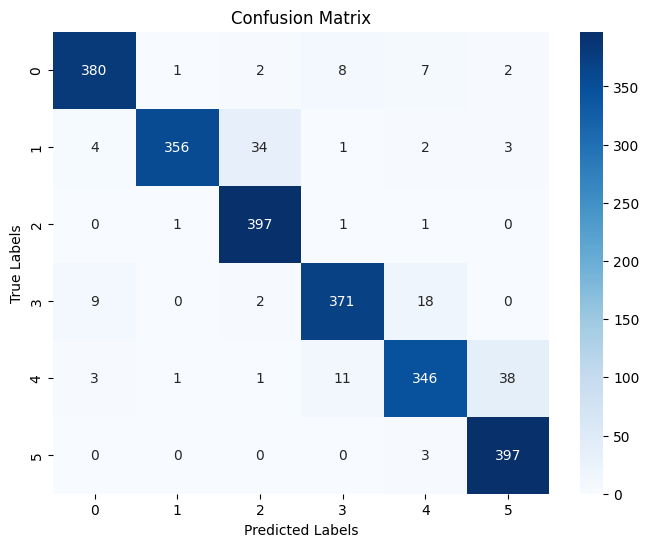

In [ ]:
# evaluation

model.eval()

all_preds = []
all_labels = []

# Disable gradient computation
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 1. Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"\nAccuracy: {acc:.4f}")

# 2–5. Precision, Recall, F1-Score, Support
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# 6. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
save_directory = '/content/drive/My Drive/University/Bachelor/FinalProject/Text_Trained_Model'

model.save_pretrained(save_directory)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.save_pretrained(save_directory)